In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
sns.set_style('darkgrid')

In [12]:
# Loading methods.
def load_from_Samples(samples_name):
    path = 'Samples/' + samples_name + '/'
    
    samples = np.load(path + 'samples.npy')
    
    with open(path + 'generator_model_params.pkl', 'rb') as f:
        generator_model_name = pkl.load(f)
        generator_model_params = pkl.load(f)
    
    with open(path + 'graph_generator_params.pkl', 'rb') as f:
        graph_generator_name = pkl.load(f)
        graph_generator_params = pkl.load(f)
    
    with open(path + 'sampling_method_params.pkl', 'rb') as f:
        sampling_method_name = pkl.load(f)
        sampling_method_params = pkl.load(f)
    
    generator_model_theta = np.load(path + 'generator_model_theta.npy')
    
    return samples, (generator_model_name, generator_model_params), generator_model_theta, \
           (graph_generator_name, graph_generator_params), \
           (sampling_method_name, sampling_method_params)


def load_likelihoods(samples_name, experiment_name):
    path = 'Samples/' + samples_name + '/' + experiment_name + '/likelihoods.pkl'
    with open(path, 'rb') as f:
        likelihoods = pkl.load(f)
    return likelihoods

In [13]:
# Plotting methods.
def plot_samples_univariate_distr(samples, model_name):
    rows, nr_variables = samples.shape
    ncols = 3
    nrows = nr_variables // 3
    if(nr_variables % 3 != 0):
        nrows += 1
    
    fig = plt.figure(figsize=(12, 15))
    fig.suptitle('Node conditional distributions for a sample from ' + model_name, fontsize=15)
    fig.tight_layout(pad=5.0)
    fig.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95)
    
    #fig.subplots_adjust(hspace=10, wspace=10)
    for idx in range(nr_variables):
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        ax.set_xlabel('Node ' + str(idx+1) + ' values')
        sns.distplot(samples[:, idx], ax=ax)
    plt.show()

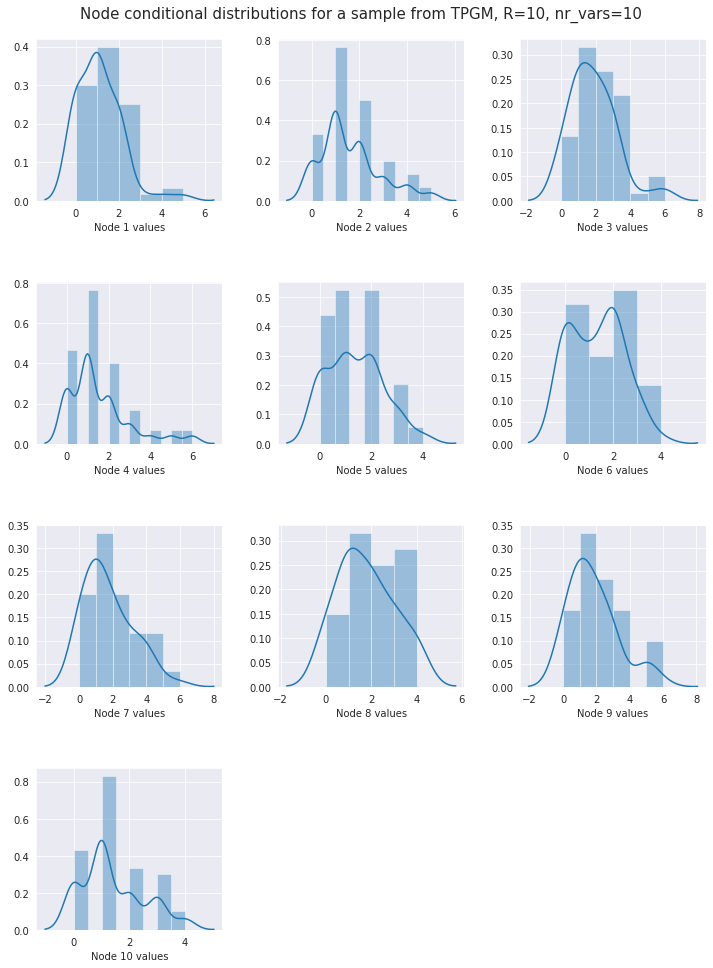

In [4]:
samples = load_from_Samples('lattice_test')[0]
plot_samples_univariate_distr(samples, 'TPGM, R=10, nr_vars=10')

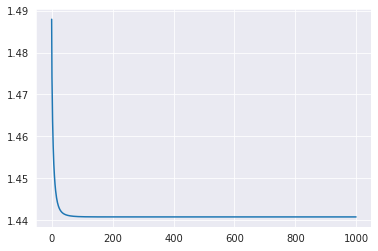

In [14]:
likelihoods = load_likelihoods('test', 'TPGM_fit_test')
plt.plot(likelihoods[0])
plt.show()

In [6]:
len(likelihoods)

10